# Instacart: Random Forest ParameterGrid Search

Random forests have a convenient property which we exploited in
hyperparameter tuning. Bootstrap samples are chosen so that [approximately 1/3 of instances are left out](https://en.wikipedia.org/wiki/Bootstrap_aggregating#Description_of_the_technique). Therefore, for any 
\(\gamma \in \Gamma_\text{train}\), the observation
\((x^\gamma, y^\gamma) \in X_\text{train} \times y_\text{train}\) is
left out of approximately 1/3 of the samples.

The motivation for using OOB estimates instead of \(N\)-fold
cross-validation is two-fold. First, this simplifies the phases of the
overall project. Second, \(N\)-fold cross-validation with
[`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
requires scikit-learn to split and copy the dataset \(N\) times, which,
in addition to parallelization, causes a memory spike that the 16GB
Kaggle Kernel cannot handle, even using \(N=3\), for a feature set of
reasonable size.

[A Stack Overflow post](https://datascience.stackexchange.com/a/30408)
was insightful in devising a strategy to calculate OOB estimates using
different metrics. To use OOB estimates with the `sklearn` interface, we
construct the hyperparameter search somewhat manually with
[`sklearn.model_selection.ParameterGrid`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html),
which essentially creates a Python iterator from a dictionary of
parameters, `param_grid`. Once we have trained a random forest
classifier on a combination of parameters in `param_grid`, we expose the
probabilistic OOB estimates with the
[`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
attribute `oob_decision_function_`. Then we can score all OOB estimates
using the metrics described in the next section.

Not all of the metrics we compute below are necessarily relevant. In particular, Log
Loss and Cohen's Kappa are included 1) out of curiosity and 2) because
seven is prime; we should not pay much attention to these metrics except
as an exploration into the behavior of the metrics themselves.

In [1]:
# Import necessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import datetime
import seaborn as sns

pd.options.display.latex.repr=True

from scipy.stats import randint, geom

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

from imblearn.metrics import geometric_mean_score



Using TensorFlow backend.


In [2]:
store = pd.HDFStore('../input/io.h5', 'r')
store.open()
store.keys()

dsets = ['train',
         'test',
         'kaggle']

X = dict.fromkeys(dsets)
y = dict.fromkeys(dsets)

for ds in dsets:
    X[ds] = store['/X/' + str(ds)]
    y[ds] = store['/y/' + str(ds)]

store.close()
store.is_open

Opening ../input/io.h5 in read-only mode


False

We have a slight data imbalance:

In [3]:
skew_train = ((y['train'].count() - y['train'].sum())/y['train'].sum())

skew_test = ((y['test'].count() - y['test'].sum())/y['test'].sum())

print('Ratio of negative class to positive class: Skew = %.4f' % skew_train)

Ratio of negative class to positive class: Skew = 9.2007


[This paper](https://www.pitt.edu/~jeffcohn/biblio/Jeni_Metrics.pdf) offers some suggestions on which metrics are useful for scoring classifiers on imbalanced data. A skew of 10 may not necessarily mean that the data is imbalanced with respect to classifier choice; but we should make sure to use metrics whose scores will not be inflated by the ease of correctly classifying the negative class.

In [4]:
rfc = RandomForestClassifier(n_estimators=35,
                             n_jobs=-1,
                             oob_score=True,
                             random_state=20190603)

In [5]:
# current grid
# (5,3) 'min_impurity_decrease' vs 'min_samples_leaf' or 'max_features'
param1 = 'min_impurity_decrease'
param2 = 'min_samples_leaf'
# param2 = 'max_features'

param_grid = {
    param1: np.geomspace(1e-8, 1e-6, 5),
    param2: np.around(np.geomspace(12, 48, 3)).astype(int)
#    param2: np.arange(6, 9)    
}

`'max_features'` seems like fine-tuning. Just use default `'sqrt'` for now. Past `param_grid`s for quick reference:

In [6]:
# # Initial coarse search parameters (superset) from another notebook:
# param_grid = {
# #    "max_depth": [4, 8, 16, 32], # does not seem helpful
#     "max_features": [5, 6, 7, 8, 9],
#     "min_samples_leaf": [4, 8, 16, 32],
#     "criterion": ["gini", "entropy"] # just use gini, should not matter
# }

In [7]:
# # (5,3) 'min_impurity_decrease' vs 'max_features'
# param1 = 'min_impurity_decrease'
# param2 = 'max_features'

# param_grid = {
#     param1: np.geomspace(1e-8, 1e-6, 5),
#     param2: np.arange(6, 9)
# }

In [8]:
# # (3,3) 'min_impurity_decrease' vs 'max_features'
# param1 = 'min_impurity_decrease'
# param2 = 'max_features'

# param_grid = {
#     param1: np.geomspace(1e-8, 1e-6, 3),
#     param2: np.arange(6, 9)
# }

In [9]:
# # testing plots
# param1 = 'min_impurity_decrease'
# param2 = 'max_features'

# param_grid = {
#     param1: [1e-6, 1e-5],
#     param2: [6, 7]
# }

In [10]:
# Double check which param_grid we set:
param_grid

{'min_impurity_decrease': array([1.00000000e-08, 3.16227766e-08, 1.00000000e-07, 3.16227766e-07,
        1.00000000e-06]), 'min_samples_leaf': array([12, 24, 48])}

Run ParameterGrid search:

In [11]:
rows = []
cols = []
decisions = []
sizes = []

for params in ParameterGrid(param_grid):
    print(datetime.datetime.now())
    print(params)
    rfc.set_params(**params)
    rfc.fit(X['train'], y['train'].values.ravel())
    rows.append(params[param1])
    cols.append(params[param2])
    decisions.append(rfc.oob_decision_function_[:, 1])
    sizes.append([rfc.estimators_[i].tree_.node_count
                  for i in range(len(rfc.estimators_))])
    
print(datetime.datetime.now())

2019-06-11 01:15:29.690404
{'min_impurity_decrease': 1e-08, 'min_samples_leaf': 12}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 01:37:08.102488
{'min_impurity_decrease': 1e-08, 'min_samples_leaf': 24}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 01:57:26.907749
{'min_impurity_decrease': 1e-08, 'min_samples_leaf': 48}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 02:16:19.822603
{'min_impurity_decrease': 3.162277660168379e-08, 'min_samples_leaf': 12}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 02:36:15.842021
{'min_impurity_decrease': 3.162277660168379e-08, 'min_samples_leaf': 24}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 02:55:16.961045
{'min_impurity_decrease': 3.162277660168379e-08, 'min_samples_leaf': 48}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 03:13:35.940819
{'min_impurity_decrease': 1e-07, 'min_samples_leaf': 12}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 03:31:09.356869
{'min_impurity_decrease': 1e-07, 'min_samples_leaf': 24}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 03:48:04.631981
{'min_impurity_decrease': 1e-07, 'min_samples_leaf': 48}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 04:04:16.366900
{'min_impurity_decrease': 3.162277660168379e-07, 'min_samples_leaf': 12}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 04:18:51.334212
{'min_impurity_decrease': 3.162277660168379e-07, 'min_samples_leaf': 24}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 04:32:49.989114
{'min_impurity_decrease': 3.162277660168379e-07, 'min_samples_leaf': 48}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 04:46:25.236834
{'min_impurity_decrease': 1e-06, 'min_samples_leaf': 12}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 04:57:42.019555
{'min_impurity_decrease': 1e-06, 'min_samples_leaf': 24}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 05:09:19.610199
{'min_impurity_decrease': 1e-06, 'min_samples_leaf': 48}


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2019-06-11 05:20:37.573264


Despite any warnings about missing OOB scores, we likely have enough trees for reliable estimates since there are very few missing scores, relatively speaking. NaNs are samples which were missed by RF bootstrap sampling:

In [12]:
print('The number of NaNs is: %i' % np.isnan(decisions[0]).sum())
print('The percentage of NaNs is: {:.4%}'.format(np.isnan(decisions[0]).sum()/len(decisions[0])))

The number of NaNs is: 1
The percentage of NaNs is: 0.0000%


In [13]:
# Create a dictionary of metrics to compute multiple scores

metrics_dict = {}


metrics_dict['auc_roc'] = {'fcn' : metrics.roc_auc_score,
                        'name': 'AUC-ROC',
                        'thr' : False}

metrics_dict['auc_pr'] = {'fcn' : metrics.average_precision_score,
                        'name': 'AUC-PR',
                        'thr' : False}

metrics_dict['log_loss'] = {'fcn' : metrics.log_loss,
                        'name': 'Log Loss',
                        'thr' : False}

metrics_dict['prec'] = {'fcn' : metrics.precision_score,
                        'name': 'Precision',
                        'thr' : True}

metrics_dict['rec'] = {'fcn' : metrics.recall_score,
                        'name': 'Recall',
                        'thr' : True}

metrics_dict['f1'] = {'fcn' : metrics.f1_score,
                        'name': 'F1 Score',
                        'thr' : True}

metrics_dict['bal_acc'] = {'fcn' : metrics.balanced_accuracy_score,
                        'name': 'Balanced Accuracy',
                        'thr' : True}

metrics_dict['g_mean'] = {'fcn' : geometric_mean_score,
                        'name': 'Geometric Mean',
                        'thr' : True}

metrics_dict['kappa'] = {'fcn' : metrics.cohen_kappa_score,
                        'name': 'Cohen\'s Kappa',
                        'thr' : True}

In [14]:
def compute_score(y_true, y_proba, metric, threshold=0.5):
    """Computes score given metric dict as above
    (i.e. metric.keys() == ('fcn', 'name', 'thr'))"""
    
    y_proba_nonan = y_proba[~np.isnan(y_proba)]
    y_true_nonan = y_true[~np.isnan(y_proba)]
    
    if metric['thr'] == True:
        return metric['fcn'](y_true_nonan, (y_proba_nonan >= threshold))
    elif metric['thr'] == False:
        return metric['fcn'](y_true_nonan, y_proba_nonan)
    else:
        return np.NaN
    # try/except?

Display threshold scores for threshold which results in the same skew as $y_\text{train}$.

In [15]:
from scipy.optimize import brentq

In [16]:
# Find the binary threshold which reproduces skew_train
# for decisions array.
# Empirically, a sample of 100,000 seems sufficient for 
# three figures of precision in threshold

thresholds = []

def threshold_skewer(x, decision, sample=100000):
    decisions_sample = np.random.choice(decisions[decision], sample)
    return sum(decisions_sample < x) / (sum(decisions_sample >= x)) - skew_train

for k in range(len(decisions)):
    thresholds.append(brentq(threshold_skewer, 0, 1, args=k))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


In [17]:
# Compute scores and concatenate with corresponding parameter values

names = []
scores = []

for key, val in metrics_dict.items():
    names.append(val['name'])    
    for k in range(len(decisions)):
        scores.append(compute_score(y['train'].values.ravel(),
                                    decisions[k],
                                    val,
                                    thresholds[k]))

scores = np.array(scores).reshape((len(metrics_dict.keys()),
                                   len(decisions))).T

scores_df = pd.concat([pd.DataFrame(data=np.array([rows, cols]).T,
             columns=[param1, param2]), 
    pd.DataFrame(data=scores,
             columns=names)],
            axis=1).melt(id_vars=[param1, param2])

scores_df.rename(columns={'variable': 'score'}, inplace=True)

[Heatmap FacetGrid Example](https://stackoverflow.com/questions/41471238/how-to-make-heatmap-square-in-seaborn-facetgrid)

The first row of plots consists of rank metrics. We should pay particular attention to AUC-PR.

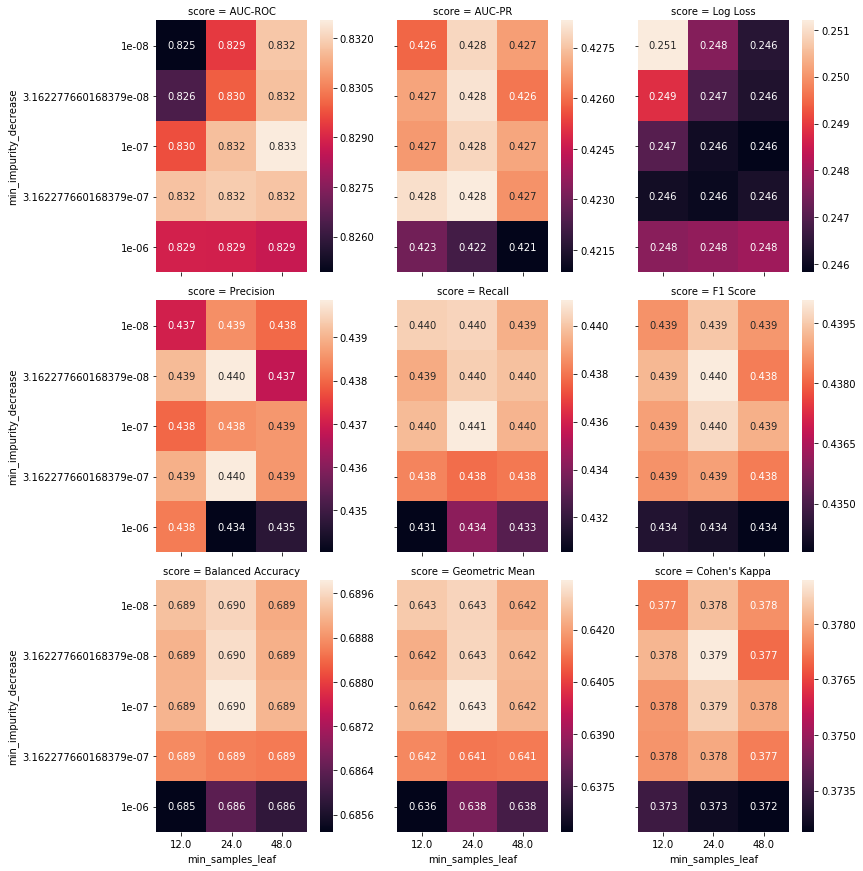

In [18]:
def draw_heatmap(index, columns, values, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=index,
                   columns=columns,
                   values=values)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(scores_df,
                   col='score',
                   col_wrap=3,
                   height=4)

fg.map_dataframe(draw_heatmap,
                 index=param1, 
                 columns=param2,
                 values='value',
                 square=True,
                 annot=True,
                 fmt='0.3f')

fg.set_axis_labels(param2, param1)

plt.show()

In [19]:
# Construct long DataFrames from (samples of) p-r curve arrays
pr_dfs_list = []
y_true = y['train'].values.ravel()

for counter, params in enumerate(ParameterGrid(param_grid)):
    pr_dict = {}
    y_proba = decisions[counter]
    y_proba_nonan = y_proba[~np.isnan(y_proba)]
    y_true_nonan = y_true[~np.isnan(y_proba)]
    precision, recall, _ = metrics.precision_recall_curve(y_true_nonan, y_proba_nonan)
    pr_dict[param1] = params[param1]
    pr_dict[param2] = params[param2]
    pr_dict['precision'] = precision[::1000]
    pr_dict['recall'] = recall[::1000]
    pr_dfs_list.append(pd.DataFrame(pr_dict))

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


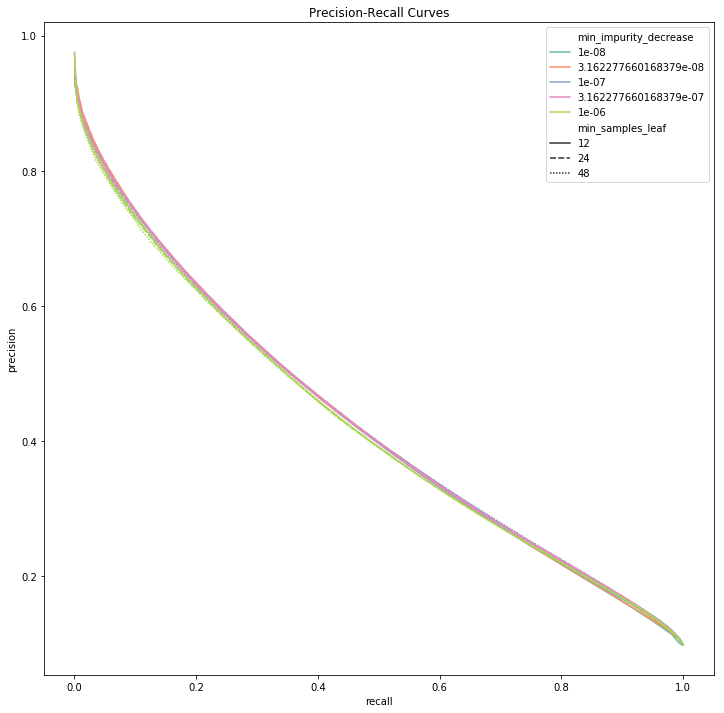

In [20]:
palette = sns.color_palette("Set2", len(param_grid[param1]))

plt.figure(figsize=(12,12))
sns.lineplot(data=pd.concat(pr_dfs_list),
             x='recall',
             y='precision',
             style=param2,
             hue=param1,
             palette=palette
             )
plt.title('Precision-Recall Curves')
plt.show()

In [21]:
# Construct long DataFrames from (samples of) roc curve arrays
roc_dfs_list = []
y_true = y['train'].values.ravel()

for counter, params in enumerate(ParameterGrid(param_grid)):
    roc_dict = {}
    y_proba = decisions[counter]
    y_proba_nonan = y_proba[~np.isnan(y_proba)]
    y_true_nonan = y_true[~np.isnan(y_proba)]
    fpr, tpr, _ = metrics.roc_curve(y_true_nonan, y_proba_nonan)
    roc_dict[param1] = params[param1]
    roc_dict[param2] = params[param2]
    roc_dict['fpr'] = fpr[::1000]
    roc_dict['tpr'] = tpr[::1000]
    roc_dfs_list.append(pd.DataFrame(roc_dict))

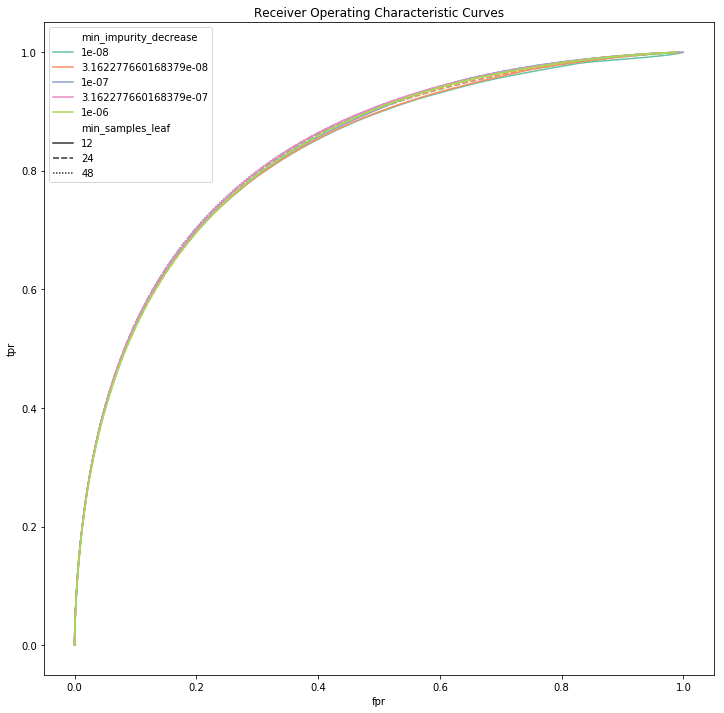

In [22]:
palette = sns.color_palette("Set2", len(param_grid[param1]))

plt.figure(figsize=(12,12))
sns.lineplot(data=pd.concat(roc_dfs_list),
             x='fpr',
             y='tpr',
             style=param2,
             hue=param1,
             palette=palette
             )
plt.title('Receiver Operating Characteristic Curves')
plt.show()